# Table of Contents
* [Preparation](#prepare)
    * [Importing Packages](#import)
    * [Hot Loading .py File](#hotload)
* [Data Decoding and Pre-processing](#ddpp)
    * [Data Decoding and Pre-processing for weather data](#ddppw)
        * [Overview for weather data](#overvieww)
        * [Data Decoding, Data Cleaning and Data Transformation for weather data](#preprocessingw)
    * [Pre-processing for traffic data](#ddppt)
        * [Overview for traffic data](#overviewt)
        * [Data Cleaning and Data Transformation for traffic data](#preprocessingt)
    * [Resample traffic data](#resamplet)
    * [Resample weather data](#resamplew)
* [Exploratory Data Analysis](#eda)
    * [Trends of Traffic Flow](#totf)
    * [Decomposition of Traffic Flow](#dotf)
        * [Decomposition of Traffic Flow by Hours](#dotf_h) 
        * [Decomposition of Traffic Flow by Days](#dotf_d)
* [Feature Selection and Engineering](#fse)
    * [Correlation Analysis](#corr)
    * [Feature Selection](#feature)
    * [Separate training and testing datasets](#separate)
* [Model Implementation](#modeling)
    * [Regression Model](#modelr)
        * [LinearRegression Model](#modellr)
        * [Lasso Regression Model](#modellasso)
    * [Time Series Model](#modelt)
        * [Holt-Winters Exponential Smoothing Model](#modelhw)
        * [SARIMAX Model](#modelsrm) 
* [Model Evaluation and Comparison](#mec)
    * [Metrics for Evaluating the Models' Performance](#metrics)
    * [Cross Validation](#cv)
        * [Cross Validation for Linear Regression Model](#cv_lr)
        * [Cross Validation for Lasso Regression Model](#cv_lasso)
        * [Cross Validation for Holt-Winters Exponential Smoothing Model](#cv_hw)
        * [Cross Validation for SARIMAX Model](#cv_sarimax)
    * [Visualize Predicting Results of Models](#vprm)
* [References](#references)

<hr style="border:2px solid black"> </hr>
<a id="prepare"><h1 style="color:deepskyblue;">Preparation</h1></a>


***
<a id="import"></a>
## Import libraries

To import the required libraries for whole project.

In [1]:
# import the build-in required libraries
import importlib # for hot-loaded .py file
import os
import warnings

# import the third-part required libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima
import seaborn as sns
import sklearn
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold, cross_val_score # Import tools for cross validation
from sklearn.preprocessing import MinMaxScaler # for normalization
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

# To ignore the future behavior of pandas
pd.set_option('future.no_silent_downcasting', True)

# To ingore the convergenceWarning
warnings.simplefilter('ignore', statsmodels.tools.sm_exceptions.ConvergenceWarning)

# check the versions of third-part libraries
print(f'matplotlib: {matplotlib.__version__}, numpy: {np.__version__}, pandas: {pd.__version__}, pmdarima: {pmdarima.__version__}')
print(f'seaborn: {sns.__version__}, sklearn: {sklearn.__version__}, statsmodels: {statsmodels.__version__}')

matplotlib: 3.8.4, numpy: 1.26.4, pandas: 2.2.2, pmdarima: 2.0.4
seaborn: 0.13.2, sklearn: 1.4.2, statsmodels: 0.14.2


***
<a id="hotload"></a>
## Hot Loading .py File

Here is to import custom .py file. It can be hot-loaded, just re-run the following cell.

Documentation comments are provided for each public function. To check the comments please use the help() function.

In [2]:
try:
    import data_process # import custom methods for data pre-processing
    import model_utils # import custom methods for model operations
    import plot_utils # import custom methods for visualization
except ModuleNotFoundError as e:
    print(f'[ERROR] fail to import a custom module at path: {os.path.abspath(".")}, msg: {e}.')
except Exception as e:
    print(f'[ERROR] fail to read module at path: {os.path.abspath(".")}, msg: {e}')
else:
    # Hot loading python files
    importlib.reload(data_process)
    importlib.reload(model_utils)
    importlib.reload(plot_utils)
    # Read the instruction for the custom load data method
    help(data_process)

Help on module data_process:

NAME
    data_process - It is a custom Python module for data process.

FUNCTIONS
    average_fill(data: pandas.core.frame.DataFrame)
        Replace missing values by the average of the forward and backward values for a DataFrame.
        
        Parameters:
            - data: pd.DataFrame.
        Returns:
            - new_data: pandas DataFrame.
    
    extract_values(data: pandas.core.frame.DataFrame, source_col: str, cols: [<class 'str'>], saved_cols: [<class 'str'>], validated_col: str = None, validated_code: str = '1', convert_cols_to_int: [<class 'str'>] = None)
        Extract values from multi-values in a string within pd.DataFrame.
        
        Parameters:
            - data: pd.DataFrame.
            - source_col: str, the name of the target column.
            - cols: list(str), new column names.
            - saved_cols: list(str), the remaining columns.
            - validated_col: str, the name of the validated column.
            -

<hr style="border:2px solid black"> </hr>
<a id="ddpp"><h1 style="color:deepskyblue;">Data Decoding and Pre-processing</h1></a>
These are a dataset of Traffic Flow data by time in a certain route of Englandand a dataset of Weather Record provided by National Centers for Environmental Information US Air Force  from 2021 to 2024. The main purposes of this work are analysing and predicting traffic flow using historical traffic and weather data.

***
<a id="ddppw"></a>
## Data Decoding and Pre-processing for weather data

<a id="overvieww"></a>
### Overview for Weather Data
The weather data contains the information of the station, key features of the weather and details of the weather features as the below table shown.
As the data focused on the only one relative station, all information of the station could be ignored. Some key features of the weather directly related to traffic should be considered, such as wind, cloud, temperature, drew point and sea level. But other detailed information would be removed as they do not directly affect the traffic. Thus, only columns, **DATE, REPORT_TYPE, WND, CIG, VIS, TMP, DEW and SLP**, will be selected for subsequent analysis.

Column|Description|Datatype
-|:-|:-
STATION	| The measurement station code | Nominal
DATE	| The date and time of the weather | Ratio
SOURCE | The source code: 4 | Nominal
LATITUDE | The latitude of the station | Ratio
LONGITUDE | The longitude of the station | Ratio
ELEVATION | The elevation of the station | Ratio
NAME | The station name | Nominal
REPORT_TYPE | Report type: FM-12: SYNOP Report of surface observation form a fixed land station, FM-15: METAR Aviation routine weather report, FM-16: SPECI Aviation selected special weather report | Nominal
CALL_SIGN | Call letter: 99999 = Missing | Nominal
QUALITY_CONTROL | Quality code: V020 | Nominal
WND | Wind observation, eg: 330,1,N,0021,1 | -
CIG | Sky condition observation, eg: 99999,9,9,9 | -
VIS | Visibility observation, eg: 000100,1,9,9 | -
TMP | Air temperature observation, eg: -0010,1 | -
DEW | Air temperature observation dew point, eg: -0013,1 | -
SLP | Air pressure observation sea level pressure, eg: 10096,1 | -
other columns | Details of the weather features | -

In [3]:
# Load weather data with selected columns and rename columns
weather_path = 'data/weather/'
weather_columns = ['DATE', 'REPORT_TYPE', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP']
weather_rename_columns = ['date', 'report_type', 'wnd', 'cig', 'vis', 'tmp', 'dew', 'slp']
weather = data_process.load_data(weather_path, columns=weather_columns, rename_columns=weather_rename_columns)
weather

,date,report_type,wnd,cig,vis,tmp,dew,slp
0,2021-01-01T00:00:00,FM-12,"330,1,N,0021,1","99999,9,9,9","000100,1,9,9","-0010,1","-0013,1","10096,1"
1,2021-01-01T00:50:00,FM-15,"350,1,N,0015,1","99999,9,9,N","000250,1,9,9","-0010,1","-0010,1","99999,9"
2,2021-01-01T01:00:00,FM-12,"350,1,N,0015,1","99999,9,9,9","000200,1,9,9","-0012,1","-0015,1","10098,1"
3,2021-01-01T01:50:00,FM-15,"330,1,N,0026,1","99999,9,9,N","000200,1,9,9","-0010,1","-0020,1","99999,9"
4,2021-01-01T02:00:00,FM-12,"330,1,N,0026,1","99999,9,9,9","000200,1,9,9","-0014,1","-0017,1","10101,1"
...,...,...,...,...,...,...,...,...
17493,2024-09-08T20:00:00,FM-12,"260,1,N,0026,1","22000,1,9,N","055000,1,9,9","+0154,1","+0134,1","10042,1"
17494,2024-09-08T20:20:00,FM-15,"250,1,N,0036,1","02743,1,C,N","009999,1,9,9","+0150,1","+0140,1","99999,9"
17495,2024-09-08T20:50:00,FM-15,"250,1,N,0031,1","99999,9,9,N","009999,1,9,9","+0150,1","+0140,1","99999,9"
17496,2024-09-08T21:00:00,FM-12,"250,1,N,0031,1","22000,1,9,N","035000,1,9,9","+0150,1","+0136,1","10042,1"


In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86855 entries, 0 to 17497
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         86855 non-null  object
 1   report_type  86855 non-null  object
 2   wnd          86855 non-null  object
 3   cig          86855 non-null  object
 4   vis          86855 non-null  object
 5   tmp          86855 non-null  object
 6   dew          86855 non-null  object
 7   slp          86855 non-null  object
dtypes: object(8)
memory usage: 6.0+ MB


In [5]:
weather.describe()

,date,report_type,wnd,cig,vis,tmp,dew,slp
count,86855,86855,86855,86855,86855,86855,86855,86855
unique,86824,3,919,665,138,431,345,729
top,2023-07-25T00:20:00,FM-15,"220,1,N,0031,1","99999,9,9,N","009999,1,9,9","+0100,1","+0090,1","99999,9"
freq,2,54189,628,15031,41003,4310,4919,55299


<a id="preprocessingw"></a>
### Data Decoding, Data Cleaning and Data Transformation for weather data

#### Remove irrelevant report data

For the weather dataset, in terms of report type, FM-12 stands for SYNOP report of surface observation form a fixed land station, FM-15 means METAR aviation routine weather report and FM-16 means SPECI aviation selected special weather report, which means FM-12 Data is more suitable for the traffic on the land.

In [6]:
# Keep weather data of FM-12 report type 
weather = weather[weather.report_type == 'FM-12']
# Drop report_type column as it is no longer needed
weather = weather.drop(columns='report_type')

####  Decode weather features
For columns WND(wind), CIG(cloud), VIS(visibility), TMP(air temperature), DEW(dew point) and SLP(sea level pressure), values were constracted by multiply attributes. For instance, SLP contains sea level and quality code (eg: "10096,1") should be extracted the number of sea level for further analysis.

Column|Description|Datatype
-|:-|:-
WND | Wind observation (angle: 001-360 degree, quality code: 0-gross limits check, 1-pass all check, type code: N-Normal, speed rate: 0000-9999 meters per second, scaling factor: 10, speed quality code: 1-pass all check), eg: 330,1,N,0021,1 | Ratio/Norminal/Norminal/Ratio/Norminal
CIG | Sky condition observation (the height above ground level of the lowest cloud: 0-22000 meters 99999=missing, ceiling quality code: 1-pass all check, 9-passed gross limits check if element is present ceiling determination code: 9-Missing, Ceiling and Visibility Okay code: N-No, Y-Yes, 9-Missing), eg: 99999,9,9,9 | Ratio/Norminal/Norminal/Norminal
VIS | Visibility observation (The horizontal distance: 0-160000 meter 999999=missing, distance quality code: 1-pass all check, variability code: N-Not variable, V-Variable, 9-Missing, quality variability code: 1-pass all checks, 9-pass gross limites check), eg: 000100,1,9,9 | Ratio/Norminal/Norminal/Norminal
TMP | Air temperature observation (The temperature of the air: -932 - 618 Degrees Celsius, scaling factor: 10, 9999-Missing quality code: 1 pass all check), eg: -0010,1 | Ratio/Norminal
DEW | Air temperature observation dew point (dew point temperature: -982 - 368 degrees celsius, scaling factor: 10, 9999-missing, quality code: 1 pass all check), eg: -0013,1 | Ratio/Norminal
SLP | Air pressure observation sea level pressure (sea level pressure: 8600 - 10900 hectopascals, scaling factor: 10, 99999=missing, quality code: 1 pass all check), eg: 10096,1 | Ratio/Norminal

In [7]:
# Extract value of wind speed
weather = data_process.extract_values(weather, source_col='wnd', cols=['wnd_angle', 'wnd_qc', 'wnd_tq', 'wnd_speed', 'wnd_speed_qc'],
               saved_cols=['wnd_speed'], validated_col='wnd_speed_qc', convert_cols_to_int=['wnd_speed'])
# Extract value of cloud height
weather = data_process.extract_values(weather, source_col='cig', cols=['cig_height', 'cig_qc', 'cig_dc', 'cig_cavok'],
               saved_cols=['cig_height'], validated_col='cig_qc', convert_cols_to_int=['cig_height'])
# Extract value of visible distance
weather = data_process.extract_values(weather, source_col='vis', cols=['vis_dist', 'vis_qc', 'vis_vc', 'vis_vqc'],
               saved_cols=['vis_dist'],validated_col='vis_qc', convert_cols_to_int=['vis_dist'])
# Extract value of temperature
weather = data_process.extract_values(weather, source_col='tmp', cols=['tmp_val', 'tmp_qc'],
               saved_cols=['tmp_val'], validated_col='tmp_qc', convert_cols_to_int=['tmp_val'])
# Extract value of dew point temperature
weather = data_process.extract_values(weather, source_col='dew', cols=['dew_tmp', 'dew_qc'],
               saved_cols=['dew_tmp'], validated_col='dew_qc', convert_cols_to_int=['dew_tmp'])
# Extract value of sea level pressure
weather = data_process.extract_values(weather, source_col='slp', cols=['slp_val', 'slp_qc'],
               saved_cols=['slp_val'], validated_col='slp_qc', convert_cols_to_int=['slp_val'])
# Drop source columns as they are no longer needed
weather_multivalued_columns = ['wnd', 'cig', 'vis', 'tmp', 'dew', 'slp']
weather = weather.drop(columns=weather_multivalued_columns)
weather

,date,wnd_speed,cig_height,vis_dist,tmp_val,dew_tmp,slp_val
0,2021-01-01T00:00:00,21,60,100,-10,-13,10096
2,2021-01-01T01:00:00,15,60,200,-12,-15,10098
4,2021-01-01T02:00:00,26,60,200,-14,-17,10101
6,2021-01-01T03:00:00,15,60,100,-15,-18,10106
8,2021-01-01T04:00:00,21,60,100,-19,-21,10106
...,...,...,...,...,...,...,...
17484,2024-09-08T17:00:00,46,630,30000,181,138,10029
17487,2024-09-08T18:00:00,26,2700,55000,164,125,10034
17490,2024-09-08T19:00:00,26,2400,70001,158,128,10038
17493,2024-09-08T20:00:00,26,22000,55000,154,134,10042


#### Set weather dataframe index

Date values should be coverted to DATE format and be setted as index for further data matching.

There may be some new rows with missing weather values created due to reindexing the data.
So, we should deal with the missing values.

It is reasonable to replaces missing values with the average value of the last and the next observed value,
as the weather normally changes Continuously.

In [8]:
# Convert date format
weather.date = pd.to_datetime(weather.date)
# Set date as index
weather = data_process.set_full_time_index(weather, time_col='date', freq='h')
# Replace missing values with the average of the forward and backward values
weather = data_process.average_fill(weather)
weather

,wnd_speed,cig_height,vis_dist,tmp_val,dew_tmp,slp_val
2021-01-01 00:00:00,21.0,60.0,100.0,-10.0,-13.0,10096.0
2021-01-01 01:00:00,15.0,60.0,200.0,-12.0,-15.0,10098.0
2021-01-01 02:00:00,26.0,60.0,200.0,-14.0,-17.0,10101.0
2021-01-01 03:00:00,15.0,60.0,100.0,-15.0,-18.0,10106.0
2021-01-01 04:00:00,21.0,60.0,100.0,-19.0,-21.0,10106.0
...,...,...,...,...,...,...
2024-09-08 17:00:00,46.0,630.0,30000.0,181.0,138.0,10029.0
2024-09-08 18:00:00,26.0,2700.0,55000.0,164.0,125.0,10034.0
2024-09-08 19:00:00,26.0,2400.0,70001.0,158.0,128.0,10038.0
2024-09-08 20:00:00,26.0,22000.0,55000.0,154.0,134.0,10042.0


***
<a id="ddppt"></a>
## Pre-processing for traffic data

<a id="overviewt"></a>
### Overview of the Traffic Data
There are data from two sites in this dataset.
The data contains 24 columns and each row of data recorded the statistics traffic flow within a period (15 minutes).
As the goal of this project is predicting "the sum of the number of vehicles passing the two sites combined", we should just need to consider the total number of traffic flow, which is much more stable.
Speed-relevant columns were ignored as they do not affect the total number of vehicles.
Time Period Ending and Time Interval can be converted into each other through mathematical formulas.
But, Time Interval was selected as it is simple to be converted.
Thus, only columns, **Report Date, Time Interval, and Total Volume**, will be selected for subsequent analysis.

Column|Description|Datatype
-|:-|:-
Site Name	| The measurement site name | Nominal
Report Date	| The date of the trip | Ratio
Time Period Ending | The end of a recording time period (15 mins) | Interval
Time Interval | The time interval in a day (0 ~ 95) | Interval
l1 - l2 cm | Total flow vehicles of length within l1 ~ l2 cm | Ratio
s1 - s2 mph | Total flow vehicles of speed within s1 ~ s2 miles per hour | Ratio
Avg mph | Average Speed | Ratio
Total Volume | Total flow vehicles | Ratio

In [9]:
# Load traffic data
traffic_path = 'data/traffic/'
columns = ['Report Date', 'Time Interval', 'Total Volume']
rename_columns = ['date', 'interval', 'total']
traffic1 = data_process.load_data(traffic_path, columns=columns, keyword='19078', rename_columns=rename_columns)
traffic2 = data_process.load_data(traffic_path, columns=columns, keyword='19124', rename_columns=rename_columns)
traffic1

,date,interval,total
0,27/01/2021 00:00:00,0,NaN
1,27/01/2021 00:00:00,1,NaN
2,27/01/2021 00:00:00,2,NaN
3,27/01/2021 00:00:00,3,NaN
4,27/01/2021 00:00:00,4,NaN
...,...,...,...
20343,31/07/2024 00:00:00,91,NaN
20344,31/07/2024 00:00:00,92,NaN
20345,31/07/2024 00:00:00,93,NaN
20346,31/07/2024 00:00:00,94,NaN


In [10]:
traffic1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122588 entries, 0 to 20347
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      122588 non-null  object 
 1   interval  122588 non-null  int64  
 2   total     113833 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.7+ MB


In [11]:
traffic1.describe()

,interval,total
count,122588.000000,113833.000000
mean,47.501370,528.408783
std,27.710835,374.333014
min,0.000000,0.000000
25%,24.000000,133.000000
50%,48.000000,544.000000
75%,72.000000,854.000000
max,95.000000,1537.000000


<a id="preprocessingt"></a>
### Data Cleaning and Data Transformation for traffic data

#### Set traffic dataframe index

As shown above, the format of date column is string and it should be coverted to DATE format and be setted as index for further operation.

In [12]:
# Convert date and interval to DATA format for site 1
traffic1.date = pd.to_datetime(traffic1.date, format='%d/%m/%Y %H:%M:%S') + pd.to_timedelta(traffic1.interval*15, unit='m')
traffic1 = data_process.set_full_time_index(traffic1, time_col='date', freq='15min')
# Drop date and interval columns as they are no longer used for site 1
drop_columns = ['interval']
traffic1.drop(columns=drop_columns, inplace=True)
# Convert date and interval to DATA format for site 2
traffic2.date = pd.to_datetime(traffic2.date, format='%d/%m/%Y %H:%M:%S') + pd.to_timedelta(traffic2.interval*15, unit='m')
traffic2 = data_process.set_full_time_index(traffic2, time_col='date', freq='15min')
# Drop date and interval columns as they are no longer used for site 2
traffic2.drop(columns=drop_columns, inplace=True)

#### Remove empty rows for traffic data and add the two sites data

As shown above, there are some empty values in total columns of the dataframes.
Here we use a custom method to remove empty rows at both ends and set the other empty values by 0.
Additionally, we add the flows of two sites.

In [13]:
# Remove empty rows
traffic1 = data_process.trim_and_fill_dataframe(traffic1, 0)
traffic2 = data_process.trim_and_fill_dataframe(traffic2, 0)
# Replace missing values with the average of the forward and backward values
traffic = data_process.average_fill(traffic1)
traffic2 = data_process.average_fill(traffic2)
# Add the total number of traffic
traffic.total = traffic.total + traffic2.total
traffic

,total
2021-02-02 00:00:00,17.0
2021-02-02 00:15:00,5.0
2021-02-02 00:30:00,6.0
2021-02-02 00:45:00,3.0
2021-02-02 01:00:00,5.0
...,...
2024-05-31 23:00:00,425.0
2024-05-31 23:15:00,251.0
2024-05-31 23:30:00,224.0
2024-05-31 23:45:00,186.0


As shown above, the last row of data is the first 15 minutes period in a day, which means the data for this day is incomplete.
Thus, this row of data should be removed.

In [14]:
# Remove last row
traffic = traffic[: len(traffic) - 1]
len(traffic)

116640

***
<a id="resamplew"></a>
## Resample weather data

The weather sampling time (from 2021-01-01 00:00:00 to 2024-09-08 21:00:00) is much longer than the traffic sampling time (from 2021-02-02 00:00:00 to 2024-05-31 23:00:00).

Thus, it is better to select weather data to match the date range of traffic data.

Additionally, as shown above, the sampling frequencies of these two data are different.
The traffic data was collected by every 15 minutes and the weather data was collected by each hour.
Here we resample the all dataset by 3 hours, as less data can improve training and prediction efficiency and still meet the requirements.

In [15]:
# Select weather rows within the date range of the traffic data
weather = weather[(weather.index >= traffic.index.min())
                  & (weather.index <= traffic.index.max())]
# Resample weather data by 3 hour
sample_hours = 8
sample_per_day = int(24 / sample_hours)
sample_hour_str = f'{sample_hours}h'
weather = weather.resample(sample_hour_str).sum()
weather

,wnd_speed,cig_height,vis_dist,tmp_val,dew_tmp,slp_val
2021-02-02 00:00:00,417.0,990.0,56600.0,541.0,504.0,79590.0
2021-02-02 08:00:00,536.0,70650.0,100000.0,876.0,707.0,79588.0
2021-02-02 16:00:00,777.0,6240.0,82000.0,811.0,627.0,79494.0
2021-02-03 00:00:00,401.0,35890.0,135000.0,646.0,478.0,79502.0
2021-02-03 08:00:00,235.0,10080.0,109000.0,644.0,522.0,79546.0
...,...,...,...,...,...,...
2024-05-30 08:00:00,480.0,6510.0,431002.0,1131.0,768.0,80849.0
2024-05-30 16:00:00,325.0,12570.0,273000.0,1088.0,837.0,81155.0
2024-05-31 00:00:00,345.0,77100.0,395001.0,883.0,693.0,81408.0
2024-05-31 08:00:00,586.0,4620.0,480001.0,1057.0,696.0,81569.0


***
<a id="resamplet"></a>
## Resample traffic data

Here we resample traffic dataset by 3 hours.

In [16]:
# Resample traffic data
traffic = traffic.resample(sample_hour_str).sum()
traffic

,total
2021-02-02 00:00:00,10412.0
2021-02-02 08:00:00,30029.0
2021-02-02 16:00:00,14943.0
2021-02-03 00:00:00,10139.0
2021-02-03 08:00:00,30384.0
...,...
2024-05-30 08:00:00,60451.0
2024-05-30 16:00:00,40132.0
2024-05-31 00:00:00,16159.0
2024-05-31 08:00:00,64208.0


<hr style="border:2px solid black"> </hr>
<a id="eda"><h1 style="color:deepskyblue;">Exploratory Data Analysis</h1></a>

***
<a id="ds"></a>
## Descriptive Statistics

Here are descriptive statistics for weather and traffic datasets.

In [17]:
weather.describe()

,wnd_speed,cig_height,vis_dist,tmp_val,dew_tmp,slp_val
count,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000,3645.000000
mean,361.217833,53069.049383,186156.486557,886.092181,583.107270,81233.666667
std,183.417059,57210.646241,92066.519208,456.562945,397.217188,906.010533
min,35.000000,240.000000,900.000000,-480.000000,-859.000000,77265.000000
25%,227.000000,7020.000000,124000.000000,584.000000,318.000000,80694.000000
50%,328.000000,27640.000000,176700.000000,872.000000,617.000000,81311.000000
75%,463.500000,90160.000000,233000.000000,1210.000000,876.000000,81869.000000
max,1369.000000,176000.000000,565001.000000,2645.000000,1533.000000,83536.000000


In [18]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3645 entries, 2021-02-02 00:00:00 to 2024-05-31 16:00:00
Freq: 8h
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wnd_speed   3645 non-null   float64
 1   cig_height  3645 non-null   float64
 2   vis_dist    3645 non-null   float64
 3   tmp_val     3645 non-null   float64
 4   dew_tmp     3645 non-null   float64
 5   slp_val     3645 non-null   float64
dtypes: float64(6)
memory usage: 199.3 KB


In [19]:
traffic.describe()

,total
count,3645.000000
mean,32306.895473
std,17253.478103
min,0.000000
25%,17014.000000
50%,32921.000000
75%,48577.000000
max,69614.000000


In [20]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3645 entries, 2021-02-02 00:00:00 to 2024-05-31 16:00:00
Freq: 8h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   total   3645 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


***
<a id="totf"></a>
## Trends of Traffic Flow

To get an immediate sense of traffic flow, here we provide an overview of the trends of traffic flow by hours and days.

<Axes: title={'center': 'The Trend of Traffic Flow by 8 Hours'}, ylabel='Number of Flow'>

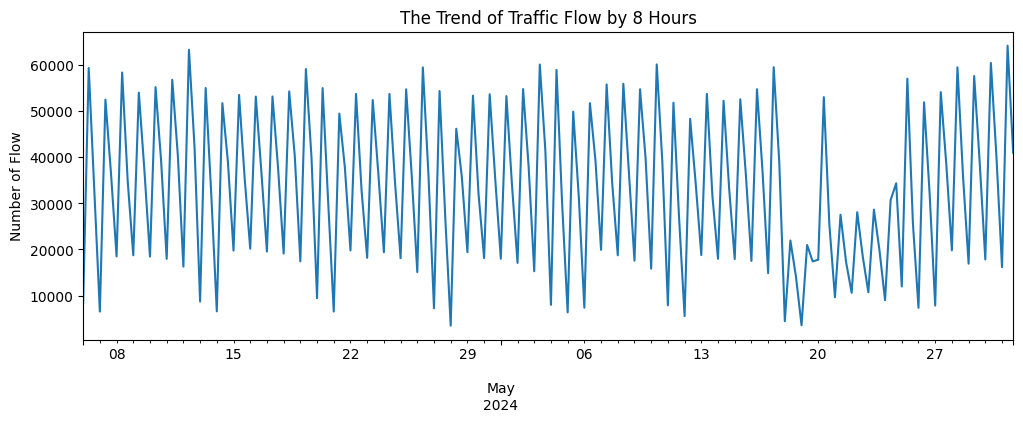

In [21]:
# A figure of the traffic flow for the last 8 weeks
disp_weeks = 8
traffic.total[-sample_per_day*7*disp_weeks:].plot(figsize=(12, 4),
                                                  ylabel='Number of Flow',
                                                  title=f'The Trend of Traffic Flow by {sample_hours} Hours')

As the figure shown above, there was a obvious pattern in the daily traffic flow, more during the day and less at night.
If we look carefully, we can find that there was another clear pattern in the weekly traffic flow, 5 days with heavy traffic and 2 days with light traffic.
Of course there was abnormal data between 18th May and 25th May.

***
<a id="dotf"></a>
## Decomposition of Traffic Flow

In real life, there are many factors that affect changes in traffic flow.

To better understand and discover the patterns of change, we use Seasonal and Trend decomposition using Loess (STL) to break down the traffic data into 3 parts, **Trend, Reasonal and Residual**.

This is especially helpful for us to interpret data by s distinguish between a general upward trend and periodic increases due to seasonality.Furthermoreyses, decomposition help us to select suitable models for prediction.

<a id="dotf_h"></a>
### Decomposition of Traffic Flow by Hours

Here we decomposit the traffic flow by hours within 10 weeks to see how trend, reasonal and residual affect the flow.

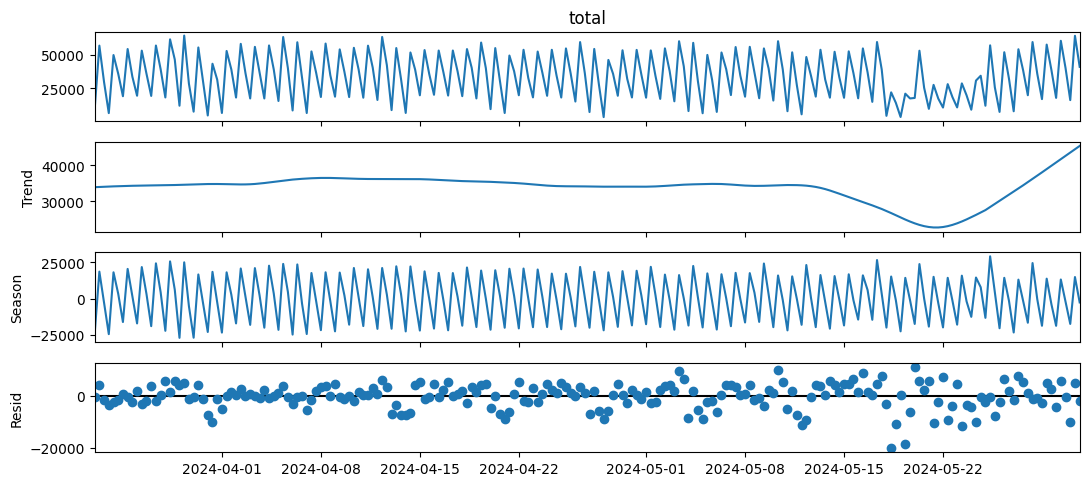

In [22]:
# init STL model and decomposit traffic flow by hours
stl = STL(traffic.total[-sample_per_day*7*10:].resample(sample_hour_str).sum(), seasonal=13).fit()
fig = stl.plot()
fig.set_size_inches((12, 5)) # Set figsize

As the figures shown above, the trend changed slowly at first,
but then dropped rapidly in 15th May until it reached the bottem on 22nd, followed by a rapid rise.

Season has relatively regular changes everyday between -25000 to 25000.

The residual value varies between -20000 and 10000.

<a id="dotf_d"></a>
### Decomposition of Traffic Flow by Days

Here we decomposit the traffic flow by days within 1 year to see how trend, reasonal and residual affect the flow.

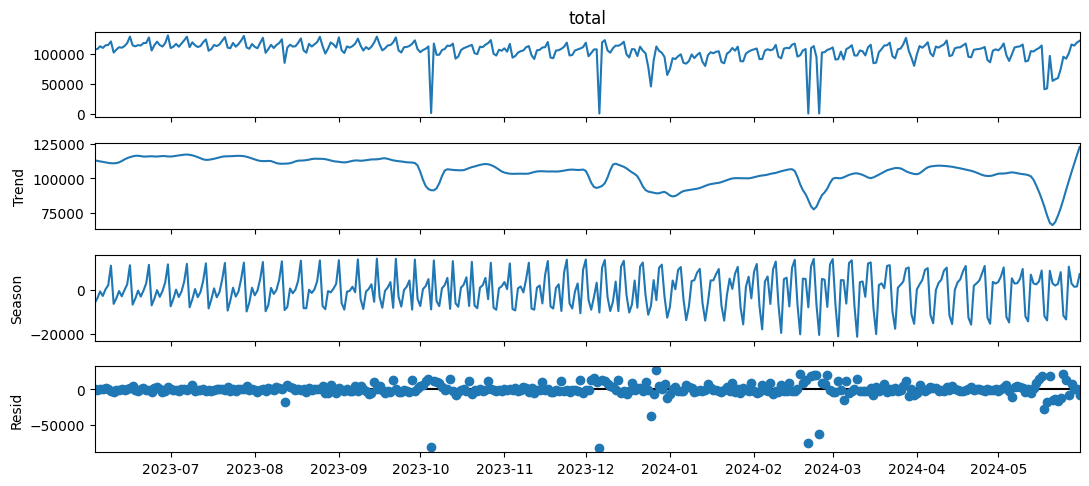

In [23]:
# init STL model and decomposit traffic flow by days
stl = STL(traffic.total[-sample_per_day*7*52:].resample('D').sum(), seasonal=13).fit()
fig = stl.plot()
fig.set_size_inches((12, 5)) # Set figsize

<a id="variation"></a>
### Variation of Weather Attributes and Traffic Flow

Here we decomposit the traffic flow by days within 1 year to see how trend, reasonal and residual affect the flow.

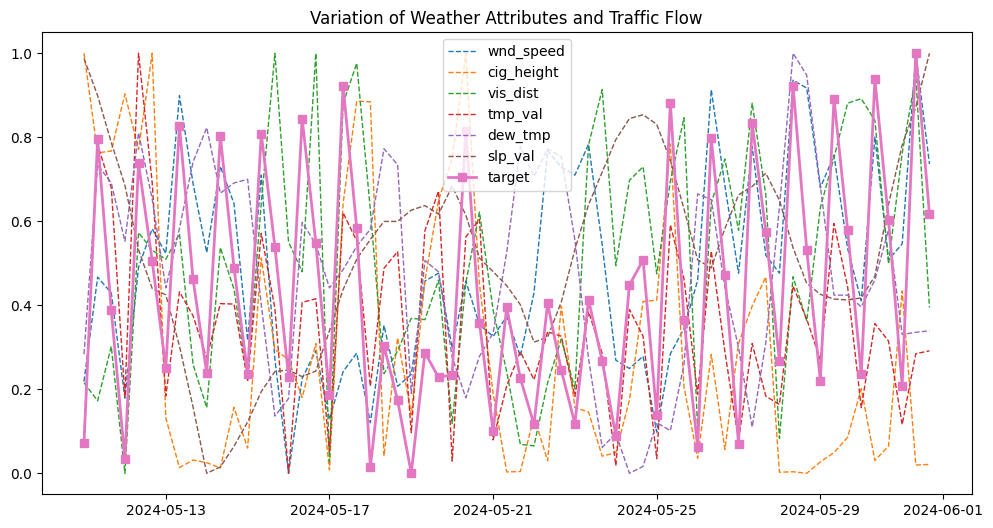

In [24]:
importlib.reload(plot_utils)

plot_utils.plot_target_exog_variables(
    x=weather[-sample_per_day*7*3:],
    y=traffic[-sample_per_day*7*3:],
    title='Variation of Weather Attributes and Traffic Flow')

As the graph shown above, normally daily traffic has relatively stable cyclical changes. From May 17th to 25th, the traffic volume decreased dramatically. The temperature during this period was also cold all day, including during the day.

<hr style="border:2px solid black"> </hr>
<a id="fse"><h1 style="color:deepskyblue;">Feature Selection and Engineering</h1></a>

***
<a id="corr"></a>
## Correlation Analysis

For a predicting problem, it is worth to assess the collinearity of the dataset [1].

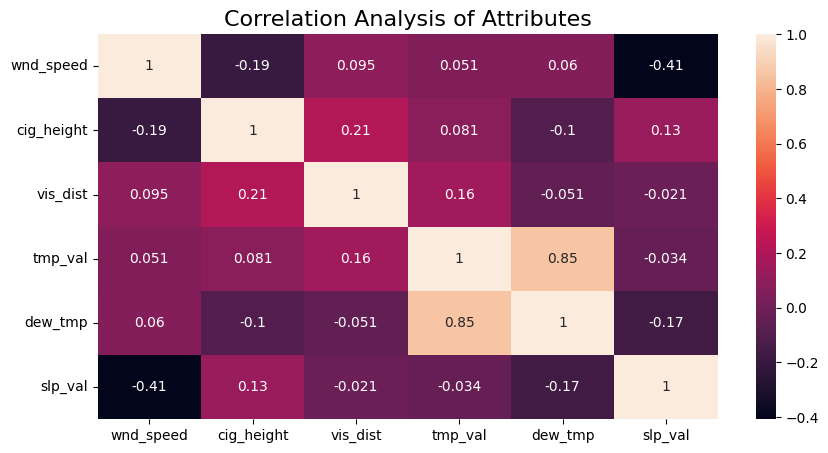

In [25]:
# Define figure size
plt.figure(figsize=(10, 5))
sns.heatmap(weather.corr(numeric_only=True), annot=True)
# Add a title
plt.title("Correlation Analysis of Attributes", fontsize=16);

***
<a id="features"></a>
## Feature Selection

As the table shown above, the correlation between Temperature and Dew Temperature (>=0.8) are considered a strong correlation, which will affect the performance of predicting models. So, Dew Temperature should be droped.

In [26]:
# Reduce correlational attributes to 1 dimension
corr_columns = ['tmp_val', 'dew_tmp']
tmp_df = data_process.reduce_dimension(weather, 1, ['tmp_pca'])
tmp_df.set_index(weather.index, inplace=True)
# Rearrage attributes
weather = pd.concat([weather, tmp_df], axis=1)
weather = weather.drop(columns=corr_columns)

***
<a id="featuree"></a>
## Feature Engineer

### Normalize weather data

Although the prediction models can be adjusted appropriately according to the parameters,
the large range differences between different parameters will still affect the performance of the models. 
Because of this, normalization should be used to process the data.

In [27]:
# define min max scaler for normalization
scaler = MinMaxScaler()
norm_weather = scaler.fit_transform(weather).round(3)
norm_weather = pd.DataFrame(norm_weather, columns = weather.columns)
weather = norm_weather.set_index(weather.index)
weather

,wnd_speed,cig_height,vis_dist,slp_val,tmp_pca
2021-02-02 00:00:00,0.286,0.004,0.099,0.371,0.411
2021-02-02 08:00:00,0.376,0.401,0.176,0.370,0.301
2021-02-02 16:00:00,0.556,0.034,0.144,0.355,0.281
2021-02-03 00:00:00,0.274,0.203,0.238,0.357,0.395
2021-02-03 08:00:00,0.150,0.056,0.192,0.364,0.410
...,...,...,...,...,...
2024-05-30 08:00:00,0.334,0.036,0.762,0.572,0.248
2024-05-30 16:00:00,0.217,0.070,0.482,0.620,0.293
2024-05-31 00:00:00,0.232,0.437,0.699,0.661,0.362
2024-05-31 08:00:00,0.413,0.025,0.849,0.686,0.279


***
<a id="separate"></a>
## Separate training and testing datasets

Here we separate the datasets to training and testing datasets for further training and testing.
We use the last 4 weeks data for testing and the rest for training.

In [28]:
# Separate training and testing datasets (The last two weeks are used for prediction)
test_weeks = 2
train_size = len(traffic) - sample_per_day * 7 * test_weeks
traffic_train, traffic_test = traffic[:train_size], traffic[train_size:]
weather_train, weather_test = weather[:train_size], weather[train_size:]
print(f'training size: ({len(weather_train)}, {len(traffic_train)}), test size: ({len(weather_test)}, {len(traffic_test)})')

training size: (3603, 3603), test size: (42, 42)


<hr style="border:2px solid black"> </hr>
<a id="modeling"><h1 style="color:deepskyblue;">Model Implement</h1></a>

***
<a id="modelr"></a>
## Regression Model



Because regression models do not accept a time series. It is useful to convert weather data to proper format for regression models.

In [29]:
# Convert weather data to the data format used by regression models
rg_weather = weather.copy()
rg_weather = data_process.prepare_data_for_regression(rg_weather)
rg_weather_train, rg_weather_test = rg_weather[:train_size], rg_weather[train_size:]
rg_weather

,wnd_speed,cig_height,vis_dist,slp_val,tmp_pca,week_of_year,day_of_week,hour
2021-02-02 00:00:00,0.286,0.004,0.099,0.371,0.411,4,1,0
2021-02-02 08:00:00,0.376,0.401,0.176,0.370,0.301,4,1,8
2021-02-02 16:00:00,0.556,0.034,0.144,0.355,0.281,4,1,16
2021-02-03 00:00:00,0.274,0.203,0.238,0.357,0.395,4,2,0
2021-02-03 08:00:00,0.150,0.056,0.192,0.364,0.410,4,2,8
...,...,...,...,...,...,...,...,...
2024-05-30 08:00:00,0.334,0.036,0.762,0.572,0.248,21,3,8
2024-05-30 16:00:00,0.217,0.070,0.482,0.620,0.293,21,3,16
2024-05-31 00:00:00,0.232,0.437,0.699,0.661,0.362,21,4,0
2024-05-31 08:00:00,0.413,0.025,0.849,0.686,0.279,21,4,8


<a id="modellr"></a>
### Linear Regression Model

Linear Regression is a simple but efficient statistical model for extracting the mapping relationship between a dependent variable (y) and one or more independent variables (xs).

It assumes that the relationship is linear.
In other words, a change of y is caused by a proportional change of xs.

#### Linear Regression with no Time-dependent Variables

In [30]:
# Fit the model
Xm = sm.add_constant(weather_train)
est_model = sm.OLS(traffic_train, weather_train).fit()
est_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.802
Model:                            OLS   Adj. R-squared (uncentered):              0.801
Method:                 Least Squares   F-statistic:                              2911.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):                        0.00
Time:                        11:34:06   Log-Likelihood:                         -40063.
No. Observations:                3603   AIC:                                  8.014e+04
Df Residuals:                    3598   BIC:                                  8.017e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
wnd_speed   3.439e+04   1760.424     19.536      0.000    3.09e+04    3.78e+04
cig_height  4578.2007    877.798      5.216      0.000    2857.169    6299.232
vis_dist    2.742e+04   1691.001     16.217      0.000    2.41e+04    3.07e+04
slp_val     3.412e+04   1406.322     24.263      0.000    3.14e+04    3.69e+04
tmp_pca    -2.174e+04   1692.463    -12.843      0.000   -2.51e+04   -1.84e+04
==============================================================================
Omnibus:                       95.562   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.193
Skew:                           0.081   Prob(JB):                     1.26e-11
Kurtosis:                       2.445   Cond. No.                         7.20
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Predict the results

In [31]:
# Use linear regression model for prediction
forecast_linear_no_time = est_model.predict(weather_test).astype(int)
forecast_linear_no_time = pd.DataFrame(forecast_linear_no_time)
forecast_linear_no_time.set_index(weather_test.index, inplace=True)

#### Linear Regression with Time-dependent Variables

In [32]:
# Fit the model
Xm = sm.add_constant(rg_weather_train)
est_model = sm.OLS(traffic_train, rg_weather_train).fit()
est_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  total   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.839
Method:                 Least Squares   F-statistic:                              2357.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):                        0.00
Time:                        11:34:06   Log-Likelihood:                         -39679.
No. Observations:                3603   AIC:                                  7.937e+04
Df Residuals:                    3595   BIC:                                  7.942e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
wnd_speed     2.567e+04   1635.534     15.698      0.000    2.25e+04    2.89e+04
cig_height    2923.7609    796.788      3.669      0.000    1361.559    4485.963
vis_dist      1.621e+04   1587.413     10.209      0.000    1.31e+04    1.93e+04
slp_val       2.412e+04   1402.307     17.201      0.000    2.14e+04    2.69e+04
tmp_pca      -1.616e+04   1556.086    -10.386      0.000   -1.92e+04   -1.31e+04
week_of_year   119.0882     15.651      7.609      0.000      88.403     149.774
day_of_week   -311.3728    121.232     -2.568      0.010    -549.063     -73.682
hour          1083.7398     38.542     28.119      0.000    1008.174    1159.306
==============================================================================
Omnibus:                      128.276   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.815
Skew:                           0.353   Prob(JB):                     3.87e-24
Kurtosis:                       2.530   Cond. No.                         237.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Predict the results

In [33]:
# Use linear regression model for prediction
forecast_linear = est_model.predict(rg_weather_test).astype(int)
forecast_linear = pd.DataFrame(forecast_linear)
forecast_linear.set_index(rg_weather_test.index, inplace=True)

##### Visualize the results

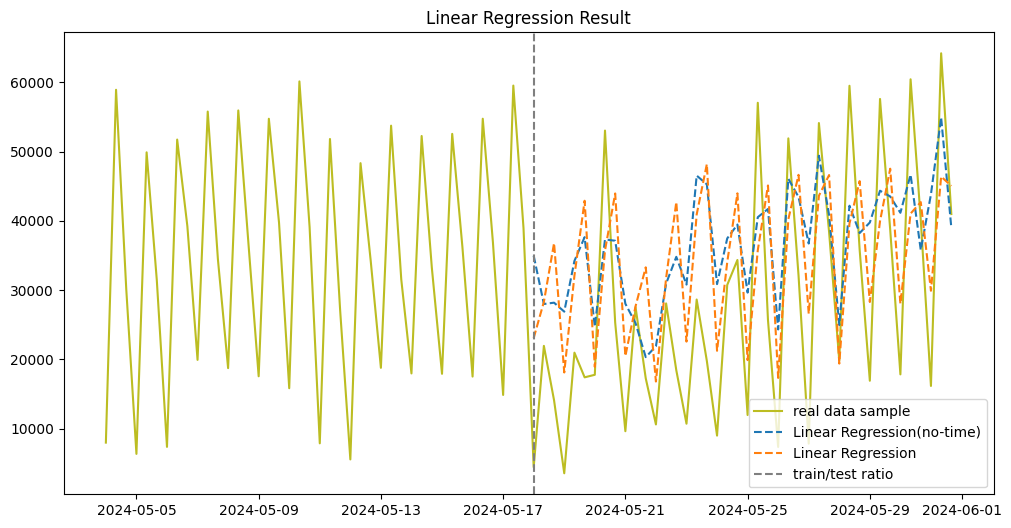

In [34]:
# Visualize the results
plot_utils.visualize_results(
    traffic[-sample_per_day*7*test_weeks*2:],
    [forecast_linear_no_time, forecast_linear],
    labels=['Linear Regression(no-time)', 'Linear Regression'],
    title='Linear Regression Result')

This figure shows that the linear regression model can fit the mean relatively well and fit the seasonal fluctuations relatively smoothly.
Additionally, it is not sensitive to outliers.

<a id="modellasso"></a>
### Lasso Regression Model

Lasso Regression adds a L1 penalty to the linear regression model. This means the penalty term is the sum of the absolute values of the coefficients.

It performs feature selection by shrinking some coefficients to zero,
and is Useful for models with many irrelevant features or when you want to simplify the model. However, it may struggle when features are highly correlated.

#### Estimate Alpha

With lasso regression we might want to learn the best value for the hyperparameter alpha.

In [35]:
# Choose KFold
kcv = KFold(n_splits=10, shuffle=True)

# Perform cross-validated Lasso
lasso_cv = LassoCV(cv=kcv)
lasso_cv.fit(rg_weather_train, traffic_train)

# Best alpha
best_alpha = lasso_cv.alpha_
best_alpha

C:\Users\weiji\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


51.77524729392174

In [36]:
# Configure the model
lasso = Lasso(alpha=best_alpha)

# Fit the model with the training data
lasso.fit(rg_weather_train, traffic_train)
lasso.coef_

array([  7567.1602191 ,   1833.30241564,  11706.36763475,   4339.63996164,
       -20924.24414727,     23.84081187,   -563.98215569,   1061.84332322])

#### Predict and visualize the results

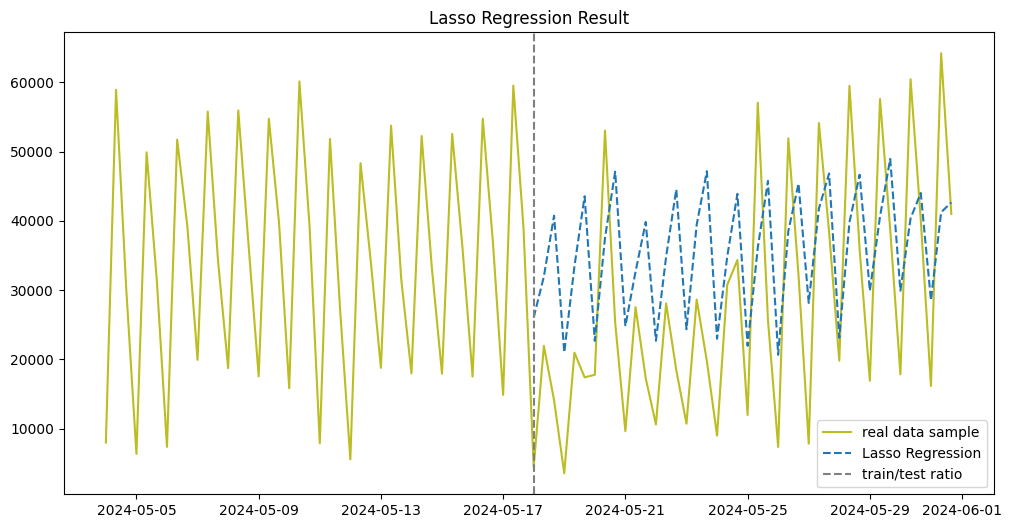

In [37]:
# Use linear regression model for prediction
forecast_lasso = lasso.predict(rg_weather_test).astype(int)
forecast_lasso = pd.DataFrame(forecast_lasso)
forecast_lasso.set_index(rg_weather_test.index, inplace=True)

# Visualize the results
plot_utils.visualize_results(
    traffic[-sample_per_day*7*test_weeks*2:],
    forecast_lasso,
    labels='Lasso Regression', 
    title='Lasso Regression Result')

This figure shows that the lasso regression model can fit the mean relatively well too and fit the seasonal fluctuations relatively smoothly.
Additionally, it is also not sensitive to outliers.

***
<a id="modelt"></a>
## Time Series Model

<a id="modelhw"></a>
### Holt-Winters Exponential Smoothing Model

AKA Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, is a popular time series forecasting method that accounts for three components: level, trend, and seasonality. It is an extension of simple and double exponential smoothing, designed to handle time series data with seasonality effectively.

Holt-Winters Exponential Smoothing does not inherently support incorporating external factors (or exogenous variables). It models a time series solely based on its internal components: level, trend, and seasonality.

In [38]:
# Fit the Holt-Winters model
holtwinters_model = ExponentialSmoothing(
    traffic_train,
    trend='add', # Additive trend
    seasonal='add', # Additive seasonality
    seasonal_periods=sample_per_day*7 # Periodicity of seasonality
).fit(optimized=True)

#### Predict and visualize the results

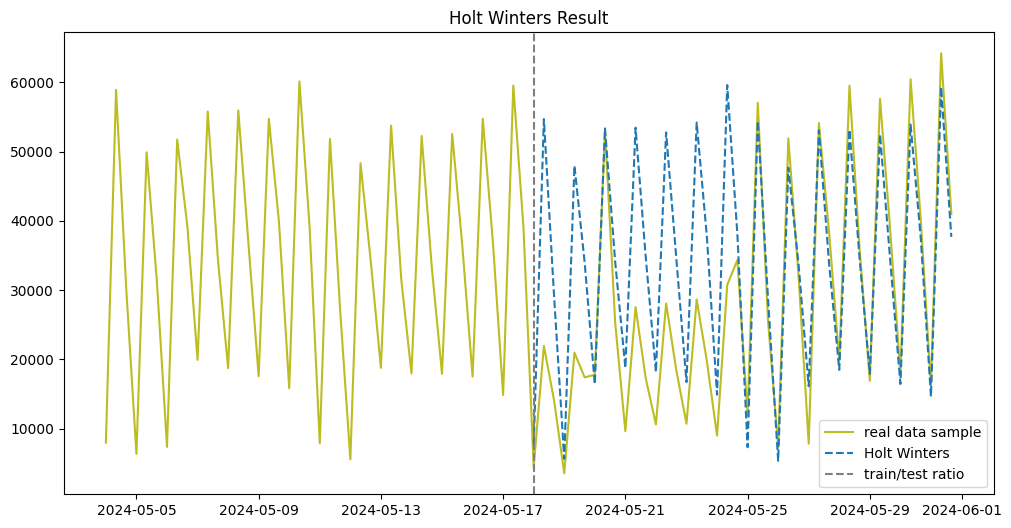

In [39]:
# Use holtwinters model for prediction
forecast_holtwinters = holtwinters_model.forecast(len(traffic_test)).astype(int)
# Visualize the results
plot_utils.visualize_results(traffic[-sample_per_day*7*test_weeks*2:], forecast_holtwinters, 'Holt Winters', 'Holt Winters Result')

This figure shows that the holt-winters model can fit the mean relatively well and fit the seasonal fluctuations relatively accurately.
However, it is sensitive to outliers.

<a id="modelsrm"></a>
### SARIMAX Model

Seasonal AutoRegressive Integrated Moving Average with Exogenous Regressors (SARIMAX) is a model to forecast future values of a time series [2]. SARIMAX is an extension of the SARIMA model that includes exogenous (external) variables, allowing it to account for additional information that may influence the time series.

### Automatically Search the Best Parameters for SARIMAX by function Auto_arima

Auto_arima is a function from the pmdarima library that automates the process of building and selecting an SARIMA model for time series forecasting. It performs parameter tuning for the SARIMA model by trying different combinations of p, d, and q, or P, D, Q, and m, and selecting the best-performing model based on specified criteria (e.g., AIC or BIC).

In [40]:
# Training data size for searching the best parameters
size_for_search = sample_per_day*7*test_weeks*5
# Use auto_arima to search the best parameters for SARIMAX
model_auto_arima = pmdarima.auto_arima(
    traffic_train[-size_for_search:],
    start_p=0, max_p=2, start_q=0, max_q=2, d=1, # Limit the search scope of (p, d, q)
    exogenous=weather_train[-size_for_search:],  # Exogenous variables
    start_P=0, max_P=1, start_Q=0, max_Q=1, D=1, # Limit the search scope of (P, D, Q)
    seasonal=True, m=sample_per_day*7,  # Assuming seasonality, the change cycle is one week
    stepwise=False,  # Not use step-by-step search optimization
    n_jobs=-1, # Use all cores for parallel computing
    trace=True,  # Output process information
    error_action='ignore',
    suppress_warnings=True
)
#  Get auto_arima recommanded order (p, d, q)
best_order = model_auto_arima.order
# Get auto_arima recommanded seasonal_order
best_seasonal_order = model_auto_arima.seasonal_order
model_auto_arima.summary()


Best model:  ARIMA(0,1,1)(1,1,0)[21]          
Total fit time: 10.402 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  210
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 21)   Log Likelihood               -1822.142
Date:                             Mon, 27 Jan 2025   AIC                           3650.284
Time:                                     11:34:17   BIC                           3659.993
Sample:                                 03-09-2024   HQIC                          3654.218
                                      - 05-17-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3846      0.037    -10.519      0.000      -0.456      -0.313
ar.S.L21      -0.1913      0.024     -8.002      0.000      -0.238      -0.144
sigma2      1.507e+07   1.18e-10   1.27e+17      0.000    1.51e+07    1.51e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.63   Jarque-Bera (JB):                41.95
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.77e+32. Standard errors may be unstable.
"""

### Use SARIMAX to model and predict

In [41]:
# Training data size for prediction
size_for_training = sample_per_day*7*test_weeks*5
# Fit SARIMA model
model_sarima = statsmodels.tsa.statespace.sarimax.SARIMAX(
    traffic_train[-size_for_training:],
    order=best_order,
    exog=weather_train[-size_for_training:],
    seasonal_order=best_seasonal_order,
    trend='t').fit()
# Print model result
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  210
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 21)   Log Likelihood               -1818.884
Date:                             Mon, 27 Jan 2025   AIC                           3655.768
Time:                                     11:34:23   BIC                           3684.896
Sample:                                 03-09-2024   HQIC                          3667.570
                                      - 05-17-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.1376      1.695     -0.081      0.935      -3.461       3.185
wnd_speed    466.8736   3312.159      0.141      0.888   -6024.838    6958.586
cig_height -1014.1799   1108.593     -0.915      0.360   -3186.983    1158.623
vis_dist    1490.7301   1406.105      1.060      0.289   -1265.185    4246.645
slp_val     -170.6796   4367.211     -0.039      0.969   -8730.256    8388.896
tmp_pca     8558.3925   5783.749      1.480      0.139   -2777.547    1.99e+04
ma.L1         -0.4098      0.043     -9.427      0.000      -0.495      -0.325
ar.S.L21      -0.1969      0.026     -7.525      0.000      -0.248      -0.146
sigma2      1.478e+07      4.196   3.52e+06      0.000    1.48e+07    1.48e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.06   Jarque-Bera (JB):                38.75
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+22. Standard errors may be unstable.
"""

#### Predict and visualize the results

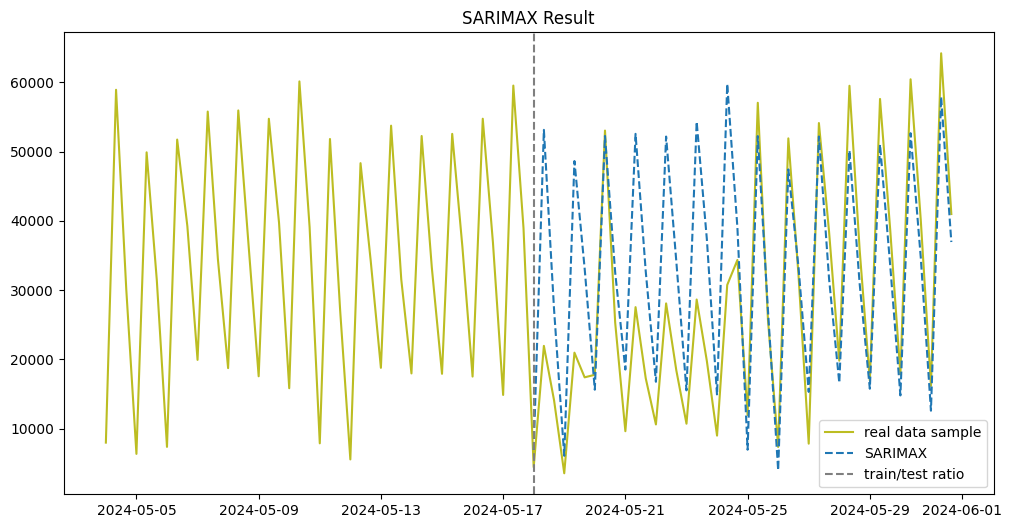

In [42]:
# Use SARIMAX model for prediction
forecast_sarimax = model_sarima.forecast(steps=len(traffic_test), exog=weather_test)
# Visualize the results
plot_utils.visualize_results(traffic[-sample_per_day*7*test_weeks*2:], forecast_sarimax, 'SARIMAX', 'SARIMAX Result')

This figure shows that the SARIMAX model can fit the mean relatively well and fit the seasonal fluctuations relatively accurately.
However, it is sensitive to outliers too.

<hr style="border:2px solid black"> </hr>
<a id="mec"><h1 style="color:deepskyblue;">Model Evaluation and Comparison</h1></a>

***
<a id="cv"></a>
## Cross Validation

Cross validation aims to address this by shuffling and then splitting the data many times and combining scores or performance over all of the splits.

There are some methods to measure the performance of regression models.

Coefficient of Determination (R2) measures the proportion of variance in the dependent variable that is explained by the independent variables. It indicates how well the model fits the data.

Root Mean Squared Error (RMSE) is the square root of the average of the squared differences between the predicted and actual values. It provides a metric with the same units as the target variable and is sensitive to outliers.

Mean Absolute Error (MAE) is the average of the absolute differences between the predicted and actual values. It treats all errors equally by taking the absolute value of the differences and is less sensitive to outliers compared to RMSE because it doesn't square the residualata.

<a id="cv_lr"></a>
### Cross Validation for Linear Regression Model

In [43]:
matrix_linear = model_utils.cross_validate_linear(
    x=rg_weather,
    y=traffic)
matrix_linear

,model,r2_score,rmse,mae
0,Lasso Regression,0.293375,14470.206621,12093.973979


<a id="cv_lasso"></a>
### Cross Validation for Lasso Regression Model

In [44]:
matrix_lasso = model_utils.cross_validate_lasso(
    x=rg_weather,
    y=traffic,
    alpha=best_alpha,
)
matrix_lasso

,model,r2_score,rmse,mae
0,Lasso Regression,0.292645,14488.383315,12156.005469


<a id="cv_hw"></a>
### Cross Validation for Holt-Winters Exponential Smoothing Model

In [45]:
matrix_holt = model_utils.cross_validate_holt(
    y=traffic,
    seasonal_periods=sample_per_day*7,
)
matrix_holt

,model,r2_score,rmse,mae
0,Holt Winters,0.830929,6835.735381,4559.663846


<a id="cv_sarimax"></a>
### Cross Validation for SARIMAX Model

In [46]:
matrix_sarimax = model_utils.cross_validate_sarimax(
    x=weather,
    y=traffic,
    order=best_order,
    seasonal_order=best_seasonal_order)
matrix_sarimax

,model,r2_score,rmse,mae
0,SARIMAX,0.080401,13742.542622,11044.26877


<a id="cv_sarimax"></a>
### Compare Performance of Models

In [47]:
matrix = pd.concat([matrix_linear, matrix_lasso, matrix_holt, matrix_sarimax], axis=0)
matrix

,model,r2_score,rmse,mae
0,Lasso Regression,0.293375,14470.206621,12093.973979
0,Lasso Regression,0.292645,14488.383315,12156.005469
0,Holt Winters,0.830929,6835.735381,4559.663846
0,SARIMAX,0.080401,13742.542622,11044.268770


The table above shows that, for the cross validation, **Holt Winters** performance better than others with the highest R2 Score, lowest Root Mean Squared Error and Mean Absolute Error. The r2 score of SARIMAX is close to 0, means that this model performs simular to a simple baseline model.

***
<a id="vprm"></a>
## Visualize Predicting Results of Models

Cross validation aims to address this by shuffling and then splitting the data many times and combining scores or performance over all of the splits.


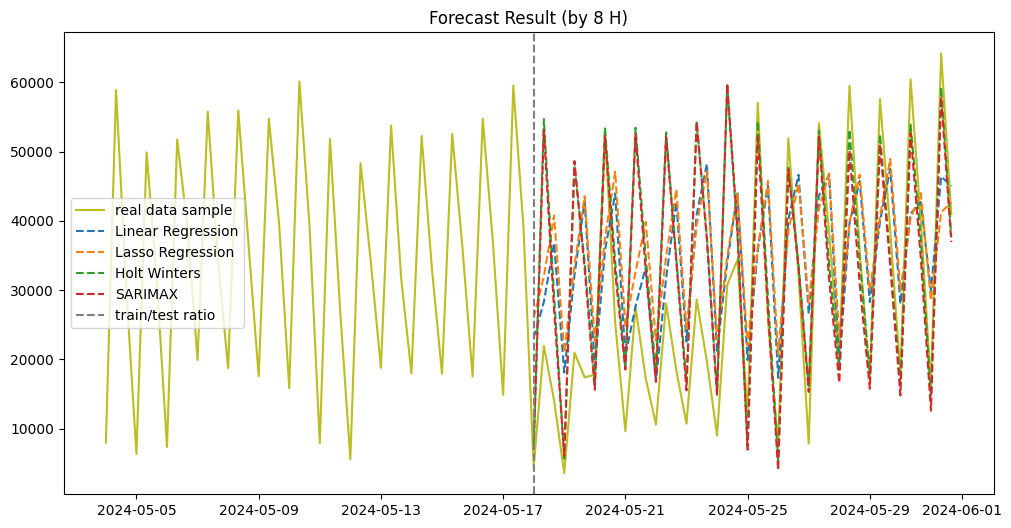

In [48]:
# Visualize the results
plot_utils.visualize_results(
    traffic[-sample_per_day*7*test_weeks*2:],
    [forecast_linear, forecast_lasso, forecast_holtwinters, forecast_sarimax],
    labels=['Linear Regression', 'Lasso Regression', 'Holt Winters', 'SARIMAX'],
    title=f'Forecast Result (by {sample_hours} H)')

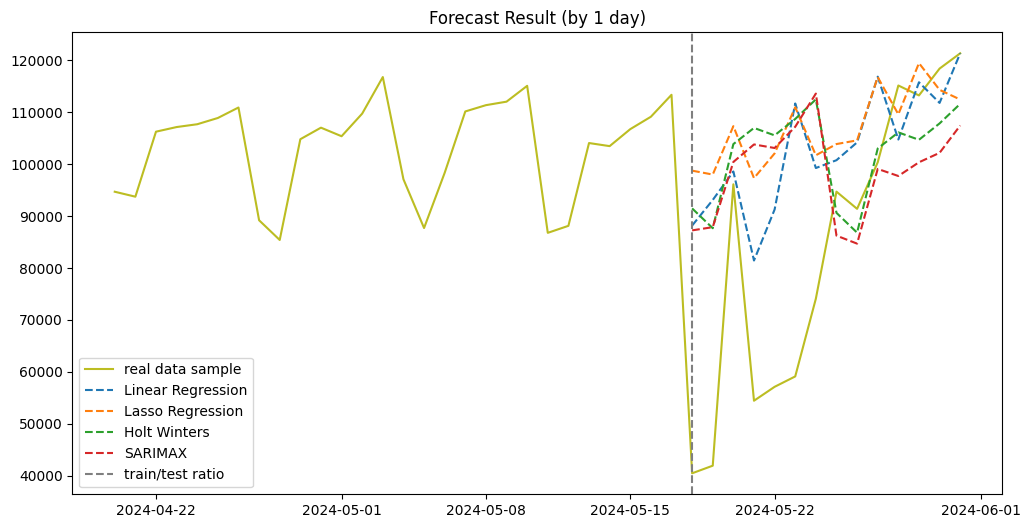

In [50]:
# Visualize the results
plot_utils.visualize_results(
    traffic[-sample_per_day*7*test_weeks*3:].resample('D').sum(),
    [forecast_linear.resample('D').sum(), forecast_lasso.resample('D').sum(), forecast_holtwinters.resample('D').sum(), forecast_sarimax.resample('D').sum()],
    labels=['Linear Regression', 'Lasso Regression', 'Holt Winters', 'SARIMAX'],
    title='Forecast Result (by 1 day)')

<hr style="border:2px solid black"> </hr>
<a id="references"><h1 style="color:deepskyblue;">References</h1></a>

- 1. Dormann, C. F., Elith, J., Bacher, S., Buchmann, C., Carl, G., Carré, G., Marquéz, J. R. G., Gruber, B., Lafourcade, B., Leitão, P. J., Münkemüller, T., McClean, C., Osborne, P. E., Reineking, B., Schröder, B., Skidmore, A. K., Zurell, D., & Lautenbach, S. (2012). Collinearity: a review of methods to deal with it and a simulation study evaluating their performance. Ecography, 36(1), 27–46. https://doi.org/10.1111/j.1600-0587.2012.07348.x
- 2. Cools, M., Moons, E., & Wets, G. (2009). Investigating the Variability in Daily Traffic Counts through use of ARIMAX and SARIMAX Models. Transportation Research Record: Journal of the Transportation Research Board, 2136(1), 57–66. https://doi.org/10.3141/2136-07